# Fitting the JWST NIRSpec Transit of WASP-107 b With an Oblate Transit Model

In [1]:
NUM_CORES = 2
import argparse
import pandas as pd

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
import numpyro_ext.distributions, numpyro_ext.optim

import os
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={NUM_CORES}"

jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(NUM_CORES)

from jaxoplanet import light_curves, orbits
from jaxoplanet.light_curves import limb_dark_light_curve
import arviz as az

from tinygp import GaussianProcess, kernels


from eclipsoid.legacy.light_curve import oblate_lightcurve_dict
import paths

oblate_lightcurve = jit(oblate_lightcurve_dict)

In [2]:
df = pd.read_csv(paths.data/'Sing_2024_Fig1_WASP107b_white_light_curve_data.csv')
t = jnp.array(df['bjd_tdb(days)'] - 2460118.948861)
nsr_1_f = jnp.array(df['NRS1_wlc_flux'])
nsr_1_f_err = jnp.array(df['NRS1_wlc_flux_err'])
nrs_2_f = jnp.array(df['NRS2_wlc_flux'])
nrs_2_f_err = jnp.array(df['NRS2_wlc_flux_err'])

In [3]:
init_params_nrs1 = {}
init_params_nrs1['f'] = 0.001
init_params_nrs1['theta'] = np.radians(20)
init_params_nrs1['u'] = jnp.array([0.15, 0.18])
init_params_nrs1['duration']=2.753/24
init_params_nrs1['bo'] = 0.11650
init_params_nrs1['t0']=0.0
init_params_nrs1['radius'] = 0.1446
init_params_nrs1['period'] = 5.7214742

init_params_nrs2 = init_params_nrs1.copy()
init_params_nrs2['u'] = jnp.array([0.11,0.13])

Text(0.5, 1.0, 'NRS2')

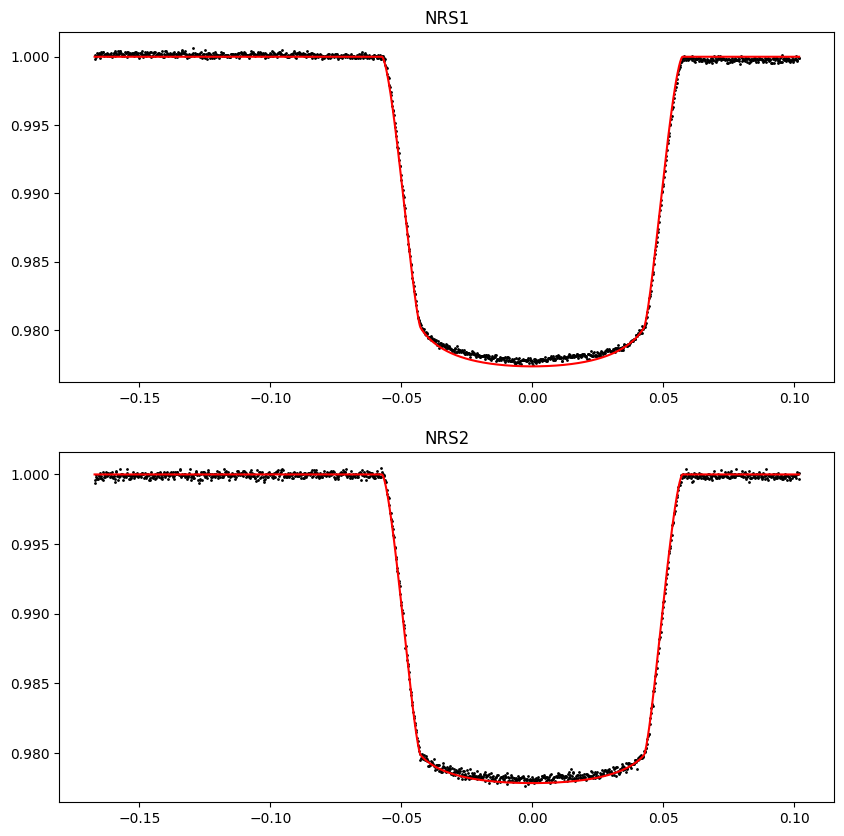

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))
ax1.scatter(t,nsr_1_f,c='k',s=1)
ax2.scatter(t,nrs_2_f,c='k',s=1)
ax1.plot(t,oblate_lightcurve(init_params_nrs1, t),c='r')
ax1.set_title("NRS1")
ax2.plot(t,oblate_lightcurve(init_params_nrs2, t),c='r')
ax2.set_title("NRS2")

In [17]:
def build_gp(t, diag, log_amp, log_ell, lc):
    kernel = jnp.exp(2 * log_amp) * kernels.quasisep.Matern32(
        jnp.exp(log_ell)
    )
    return GaussianProcess(kernel, t, diag=diag, mean=lc)

In [18]:
def model(t, yerr, y=None):
    yerr_nrs1, yerr_nrs2 = yerr
    y_nrs1, y_nrs2 = y


    r_circ = numpyro.sample("r_circ", dist.Uniform(0.02, 0.2))
    u_nrs1 = numpyro.sample("u_nrs1", distx.QuadLDParams())
    u_nrs2 = numpyro.sample("u_nrs2", distx.QuadLDParams())
    bo = numpyro.sample("bo", dist.Uniform(0.01,0.9))
    
    #parametrize f, theta using a unit disk
    hk = numpyro.sample("hk", distx.UnitDisk())
    f = numpyro.deterministic("f", (hk[0] ** 2 + hk[1] ** 2)/2)
    theta = numpyro.deterministic("theta", jnp.arctan2(hk[1], hk[0])/2)
    
    # The duration
    log_d = numpyro.sample("log_d", numpyro.distributions.Normal(jnp.log(init_params_nrs1['duration']), 0.01))
    duration = numpyro.deterministic("duration", jnp.exp(log_d))
    t0 = numpyro.sample("t0", dist.Uniform(-0.0001, 0.0001))
    
    
    params_nrs1 = {
        'period':init_params_nrs1['period'],
        't0': t0,
        "radius": jnp.sqrt(r_circ**2/(1-f)),
        'bo':bo,
        'u': u_nrs1,
        'f':f, 
        'theta':theta,
        'duration': duration
    }
    
    params_nrs2 = {
        'period':init_params_nrs1['period'],
        't0': t0,
        "radius": jnp.sqrt(r_circ**2/(1-f)),
        'bo':bo,
        'u': u_nrs2,
        'f':f, 
        'theta':theta,
        'duration': duration
    }
    
    #jitter term in ppm
    nrs1_log_jitter = numpyro.sample("nrs1_log_jitter", dist.Normal(jnp.log(jnp.median(yerr_nrs1)), 1.0))
    nrs2_log_jitter = numpyro.sample("nrs_2log_jitter", dist.Normal(jnp.log(jnp.median(yerr_nrs2)), 1.0))
    
    #add a linear trend centered on a slope of 0 and an intercept of 1
    #in ppm
    nrs1_slope = numpyro.sample("nrs1_slope", dist.Uniform(-0.001,0.001))
    nrs2_slope = numpyro.sample("nrs2_slope", dist.Uniform(-0.001, 0.001))
    nrs1_intercept = numpyro.sample("nrs1_intercept", dist.Uniform(-0.001, 0.001))
    nrs2_intercept = numpyro.sample("nrs2_intercept", dist.Uniform(-0.001, 0.001))

    #build the GP in tinygp
    log_ell_nrs1 = numpyro.sample("nrs1_log_ell", dist.Normal(jnp.log(0.02), 1.0))
    log_amp_nrs1 = numpyro.sample("nrs1_log_amp", dist.Normal(jnp.log(0.002), 1.0))
    
    log_ell_nrs2 = numpyro.sample("nrs2_log_ell", dist.Normal(jnp.log(0.02), 1.0))
    log_amp_nrs2 = numpyro.sample("nrs2_log_amp", dist.Normal(jnp.log(0.002), 1.0))
    
    
    y_pred_nrs1 = lambda t: oblate_lightcurve(params_nrs1, t)+nrs1_slope*t+nrs1_intercept
    y_pred_nrs2 = lambda t: oblate_lightcurve(params_nrs2, t)+nrs2_slope*t+nrs2_intercept
    
    nrs1_gp = build_gp(t, yerr_nrs1**2+jnp.exp(2 * nrs1_log_jitter), log_amp_nrs1, log_ell_nrs1, y_pred_nrs1)
    nrs2_gp = build_gp(t, yerr_nrs2**2+jnp.exp(2 * nrs2_log_jitter), log_amp_nrs2, log_ell_nrs2, y_pred_nrs2)


    nrs1_mu = nrs1_gp.mean_function(t)
    nrs2_mu = nrs2_gp.mean_function(t)

    numpyro.deterministic("nrs1_light_curve", nrs1_mu)
    numpyro.deterministic("nrs2_light_curve", nrs2_mu)

    numpyro.deterministic("nrs1_gp", nrs1_gp.condition(y_nrs1, t, include_mean=False).gp.loc)
    numpyro.deterministic("nrs2_gp", nrs2_gp.condition(y_nrs2, t, include_mean=False).gp.loc)
    
    numpyro.sample(
        "nrs1_flux",
        nrs1_gp.numpyro_dist(),
        obs=y_nrs1,
    )
    
    numpyro.sample(
        "nrs2_flux",
        nrs2_gp.numpyro_dist(),
        obs=y_nrs2,
    )

In [19]:
opt_init_params = {
    "r_circ": 0.1446,
    "u_nrs1": jnp.array([0.15, 0.18]),
    "u_nrs2": jnp.array([0.11, 0.13]),
    "bo": 0.11650,
    "hk": jnp.array([0.01, 0.01]),
    "log_d": jnp.log(2.753/24),
    "t0": 0.0,
    "nrs1_log_jitter": 0.0,
    "nrs2_log_jitter": 0.0,
    "nrs1_slope": 0.0,
    "nrs2_slope": 0.0,
    "nrs1_log_ell": jnp.log(0.02),
    "nrs2_log_ell": jnp.log(0.02),
    "nrs1_log_amp": jnp.log(0.002),
    "nrs2_log_amp": jnp.log(0.002),
    "nrs1_intercept": 0.0,
    "nrs2_intercept": 0.0
}

run_optim = numpyro_ext.optim.optimize(
    model,
    init_strategy=numpyro.infer.init_to_value(values=opt_init_params),
    return_info=True
)
opt_params, status = run_optim(jax.random.PRNGKey(2), t, jnp.array([nsr_1_f_err, nrs_2_f_err]), y=jnp.array([nsr_1_f, nrs_2_f]))

In [21]:
print(opt_params)

{'r_circ': Array(0.1436993, dtype=float64), 'u_nrs1': Array([0.08935279, 0.2335004 ], dtype=float64), 'u_nrs2': Array([0.06066823, 0.1844528 ], dtype=float64), 'bo': Array(0.09561883, dtype=float64), 'hk': Array([0.03295037, 0.00578587], dtype=float64), 'log_d': Array(-2.16567548, dtype=float64), 't0': Array(3.99783158e-05, dtype=float64), 'nrs1_log_jitter': Array(-11.02125701, dtype=float64), 'nrs_2log_jitter': Array(-10.31412561, dtype=float64), 'nrs1_slope': Array(-0.00099999, dtype=float64), 'nrs2_slope': Array(-0.00013358, dtype=float64), 'nrs1_intercept': Array(-1.40827706e-05, dtype=float64), 'nrs2_intercept': Array(-6.84281742e-05, dtype=float64), 'nrs1_log_ell': Array(-4.34325251, dtype=float64), 'nrs1_log_amp': Array(-9.44645163, dtype=float64), 'nrs2_log_ell': Array(-4.73173945, dtype=float64), 'nrs2_log_amp': Array(-10.06667113, dtype=float64), 'duration': Array(0.11467245, dtype=float64), 'f': Array(0.0005596, dtype=float64), 'nrs1_flux': Array([0.99982099, 1.00010382, 0.9

Text(0.5, 0, 'Time (days)')

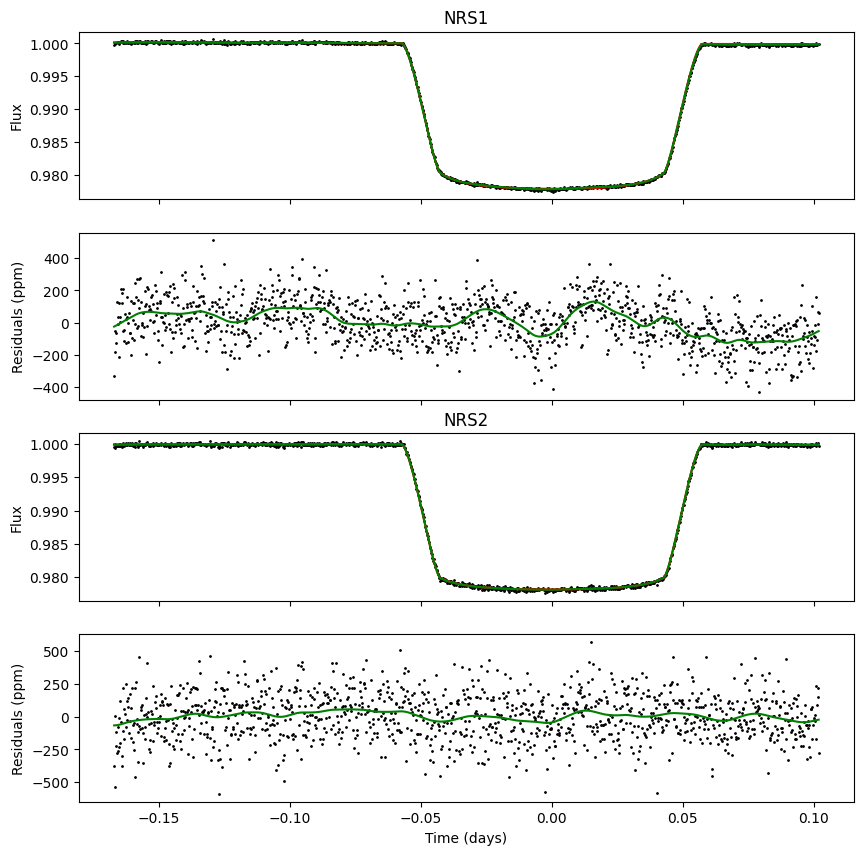

In [27]:
fig, (ax1, ax3, ax2, ax4) = plt.subplots(4,1,figsize=(10,10), sharex=True)
ax1.scatter(t,nsr_1_f,c='k',s=1)
ax2.scatter(t,nrs_2_f,c='k',s=1)
ax1.plot(t,opt_params['nrs1_light_curve'],c='b', label="mean oblate transit model")
ax1.plot(t,opt_params['nrs1_gp']+opt_params['nrs1_light_curve'],c='r', label="GP")
ax1.set_title("NRS1")
ax2.plot(t,opt_params['nrs2_light_curve'],c='b', label="mean oblate transit model")
ax2.plot(t,opt_params['nrs2_gp']+opt_params['nrs2_light_curve'],c='r', label="GP")
ax2.set_title("NRS2")
ax1.set_ylabel("Flux")
ax2.set_ylabel("Flux")
#plot residuals
ax3.scatter(t,1e6*(nsr_1_f-opt_params['nrs1_light_curve']),c='k',s=1)
ax4.scatter(t,1e6*(nrs_2_f-opt_params['nrs2_light_curve']),c='k',s=1)
ax3.plot(t,1e6*opt_params['nrs1_gp'],c='r')
ax4.plot(t,1e6*opt_params['nrs2_gp'],c='r')
ax3.set_ylabel("Residuals (ppm)")
ax4.set_ylabel("Residuals (ppm)")
ax4.set_xlabel("Time (days)")

In [9]:
sampler = infer.MCMC(
    infer.NUTS(
        model,
        target_accept_prob=0.8,
        dense_mass=True,
        regularize_mass_matrix=False,
        max_tree_depth=8,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=2000,
    num_samples=2000,
    num_chains=NUM_CORES,
    progress_bar=True,
)

%time sampler.run(jax.random.PRNGKey(10), t, jnp.array([nsr_1_f_err, nrs_2_f_err]), y=jnp.array([nsr_1_f, nrs_2_f]))

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 32.4 s, sys: 757 ms, total: 33.1 s
Wall time: 34.6 s


In [10]:
sampler.print_summary()

In [ ]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data, var_names=['r_circ', 'bo', 'u_nrs1','u_nrs2', 'f', 'theta', 'duration'])